# Feature Design for CoinHunter - prototyping a new hunting mode

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Global Constants
ACTIONS            = ['UP', 'RIGHT', 'DOWN', 'LEFT', 'WAIT', 'BOMB']
DIRECTIONS         = np.array([(0, -1), (1, 0), (0, 1), (-1, 0)])   # UP, RIGHT, DOWN, LEFT
DEFAULT_DISTANCE   = 1000
BOMB_COOLDOWN_TIME = 7
COLS = ROWS        = 17
BLAST              = np.array([-3, -2, -1, 1, 2, 3])


In [5]:

# Calculate constant BOMB_MASK one time
BOMB_MASK = np.full((COLS, ROWS, COLS, ROWS), False)

x_inside = lambda x: x > 0 and x < COLS-1
y_inside = lambda y: y > 0 and y < ROWS-1

for x in range(1, COLS-1):
        for y in range(1, ROWS-1):
            if (x % 2 == 1 or y % 2 == 1):
                explosion_spots = [(x, y)]
                if x % 2 == 1:
                    explosion_spots += [(x, y + b) for b in BLAST  if y_inside(y + b)]
                if y % 2 == 1:
                    explosion_spots += [(x + b, y) for b in BLAST  if x_inside(x + b)]
                
                explosion_spots = tuple(np.array(explosion_spots).T)
                BOMB_MASK[(x, y)][explosion_spots] \
                                = True

# Initilize dumb_bombing_map 
dump_bombing_map = np.zeros(COLS, ROWS)
cannot_bomb_ticker = 0

In [6]:
# New global Constants
FOE_TRIGGER_DISTANCE = 5
STRIKING_DISTANCE    = 3

In [5]:
def state_to_features(game_state: dict, dumb_bombing_map) -> np.array:
    """
    *This is not a required function, but an idea to structure your code.*

    Converts the game state to the input of your model, i.e. a feature vector.

    You can find out about the state of the game environment via game_state,
    which is a dictionary. Consult 'get_state_for_agent' in environment.py to see
    what it contains.

    :param game_state:  A dictionary describing the current game board.
    :return: np.array
    """
    
    
    # This is the dict before the game begins and after it ends
    if game_state is None:
        return None


    # 0. relevant game_state info
    own_position      = game_state['self'][3]
    crate_map         = game_state['field']
    can_place_bomb    = game_state['self'][2]
    collectable_coins = game_state['coins']
    bombs             = game_state['bombs']
    explosion_map     = game_state['explosion_map']
    foes              = game_state['others']

    neighbors = own_position + DIRECTIONS

    
    # 1. Calculate proximity map
    distance_map, reachability_map, direction_map = proximity_map(own_position, crate_map)


    # 2. Check for danger and lethal danger
    """
    going_is_dumb   : 
        Intuitive definition : going in that direction is suicidal
        Effect if True       : sets f1-f4 to 0
    waiting_is_dumb : 
        Intuitive definition : staying on own_position is suicidal
        Effect if True       : sets f5 to 0
    bombing_is_dumb : 
        Intuitive definition : placing a bomb on own_position is suicidal?
        Effect if True       : prevents f5 from being 2 via best_crate_bombing_spots() (only mode 1)
    """
    
    waiting_is_dumb = False
    bombing_is_dumb = False
    
    # Don't go where it's invalid or suicidal
    going_is_dumb   = np.array([( (not reachability_map[(x,y)]) or explosion_map[(x,y)] ) for [x,y] in neighbors])
    
    # Don't place a bomb if you're not able to
    if not can_place_bomb: 
        bombing_is_dumb = True 
        cannot_bomb_ticker = (cannot_bomb_ticker % 6) + 1
        if cannot_bomb_ticker == 1:
            dump_bombing_map = np.zeros(COLS, ROWS) # forget all memorized dumb bombing spots 
    
    
    # Escape bombs that are about to explode
    for (bomb_position, bomb_timer) in bombs:
        steps_until_explosion    = bomb_timer + 1
        no_future_explosion_mask = np.logical_not(BOMB_MASK[bomb_position])

        if not waiting_is_dumb:
            rescue_distances         = distance_map[reachability_map & no_future_explosion_mask]   # improve by including explosions
            minimal_rescue_distance  = DEFAULT_DISTANCE if (rescue_distances.size == 0) else np.amin(rescue_distances)
            if steps_until_explosion <= minimal_rescue_distance:
                waiting_is_dumb = True
                bombing_is_dumb = True

        safe_directions = np.any(direction_map[reachability_map & no_future_explosion_mask & (distance_map <= steps_until_explosion)], axis = 0)
        going_is_dumb[np.logical_not(safe_directions)] = True

    # Don't place a bomb you can't escape from
    if not bombing_is_dumb:
        no_future_explosion_mask = np.logical_not(BOMB_MASK[own_position])
        rescue_distances         = distance_map[reachability_map & no_future_explosion_mask] # improve by including explosions
        minimal_rescue_distance  = DEFAULT_DISTANCE if (rescue_distances.size == 0) else np.amin(rescue_distances) 
        if minimal_rescue_distance > 4:
            bombing_is_dumb = True
            dumb_bombing_map[own_position] = bombing_is_dumb 
    
    # 3. Check game mode
    reachable_coins = select_reachable(collectable_coins, reachability_map)
    if len(foes) > 0:
        foe_positions       = np.array([foe[3] for foe in foes])
        foe_positions_tuple = tuple(foe_positions.T)
        min_foe_distance    = np.amin(distance_map[foe_positions_tuple])
    else:
        min_foe_distance    = DEFAULT_DISTANCE    
    
    if min_foe_distance <= FOE_TRIGGER_DISTANCE:
        mode = 2   # Hunter mode
    elif len(reachable_coins) > 0:
        mode = 0   # Collector mode
    else:
        mode = 1   # Miner mode

 
    # 4. Compute goal direction
    if mode == 0:
        best_coins      = select_nearest(reachable_coins, distance_map)
        goals           = make_goals(best_coins, direction_map, own_position)

    if mode == 1:
        crates_destroyed     = crate_destruction_map(crate_map, bombs)
        sensible_bombing_map = sensible_bombing_spots(reachability_map, dumb_bombing_map)
        best_crate_spots     = best_crate_bombing_spots(distance_map, crates_destroyed, sensible_bombing_map)
        goals                = make_goals(best_crate_spots, direction_map, own_position)

    if mode == 2:
        closest_foe  = select_nearest(foe_positions, distance_map)
        goals        = make_goals(closest_foe, direction_map, own_position)
        if min_foe_distance <= STRIKING_DISTANCE and not bombing_is_dumb:
            goals[4] = True  

    # 5. Assemble feature array
    features = np.full(6, 1)
    
    # Directions (f1 - f4)
    for i in range(4):
        neighbor = tuple(np.array(own_position) + DIRECTIONS[i])
        if going_is_dumb[i]:
            features[i] = 0
        elif goals[i]:
            features[i] = 2

    # Own spot (f5)
    if waiting_is_dumb:
        features[4] = 0
    elif goals[4]:   # own spot is a goal
        features[4] = 2
        
    # Mode (f6)
    features[5] = mode


    return features


In [13]:
def proximity_map (own_position, game_field):
    """
    calculates three values for each tile of the game field:
    1. travel time aka. distance from own position
    2. if tile is reachable from own position or blocked
    3. in which directions one can initially go to reach that tile as quick as possible

    Arguments
    ---------
    own_position : tuple (x, y)
        with x and y being current coordinates coordinates of the agent 
        on the game field. Thus 0 < x < COLS-1, 0 < y < ROWS-1.
    game_field   : np.array, shape = (COLS, ROWS)
        = game_state['field']

    Returns
    -------
    travel_time_map         : np.array, shape like game_field, dtype = int
        Reachable tiles have the value of the number of steps it takes to move to them 
        from own_position.
        Unreachable tiles have the value of DEFAULT_TRAVEL_TIME which is much higher than 
        any reachable time.
    reachable_map           : np.array, shape like game_field, dtype = bool
        A boolean mask of travel_time_map that labels reachable tiles as True and 
        unreachable ones as False.
    original_directions_map : np.array, shape = (COLS, ROWS, 4), dtype = bool
        A map of the game_field that holds a 4-element boolean array for every tile.
        Values of the tile's array correspond to the 4 directions UP, RIGHT, DOWN, LEFT 
        which you might from own_position to reach the tile. Those direction which lead you 
        to reach the tile the fastest are marked True, the others False.
        For example, if you can reach a tile the fastest by either going UP or RIGHT at the step
        then its array will look like this [TRUE, TRUE, FALSE, FALSE].
        This map will be important to quickly find the best direction towards coins, crates,
        opponents and more.
    """


    # Setup of initial values
    distance_map  = np.full_like(game_field, DEFAULT_DISTANCE)
    direction_map = np.full((*game_field.shape, 4), False)

    distance_map[own_position] = 0
    for i, dir in enumerate(DIRECTIONS):
        neighbor = tuple(dir + np.array(own_position))
        if game_field[neighbor] == 0:   # If neighbor is a free field
            direction_map[neighbor][i] = True
    

    # Breadth first search for proximity values to all reachable spots
    frontier = [own_position]
    while len(frontier) > 0:
        current = frontier.pop(0)
        
        for dir in DIRECTIONS:
            neighbor = tuple(dir + np.array(current))
            
            # Update travel time to `neighbor` field
            if game_field[neighbor] == 0:   # If neighbor is a free field
                time = distance_map[current] + 1
                if distance_map[neighbor] > time:
                    distance_map[neighbor] = time
                    frontier.append(neighbor)
                    
                    # Update original direction for `neighbor` field
                    if time > 1:
                        direction_map[neighbor] = direction_map[current]
                        
                # Combine orginial directions if travel times are equal
                elif distance_map[neighbor] == time:
                    direction_map[neighbor] = np.logical_or(
                        direction_map[neighbor], direction_map[current])


    # Derivation of reachability_map
    reachability_map = distance_map != DEFAULT_DISTANCE


    return distance_map, reachability_map, direction_map

In [6]:
def select_reachable (positions, reachability_map):
    """
    """

    if len(positions) > 0:
        positions_array     = np.array(positions)
        positions_tuple     = tuple(positions_array.T)
        reachable_mask      = reachability_map[positions_tuple]
        reachable_positions = positions_array[reachable_mask] 
    else:
        reachable_positions = np.array(positions)

    return reachable_positions

In [7]:
def select_nearest (positions, distance_map):
    """
    """

    if len(positions) > 0:
        positions_array   = np.array(positions)
        positions_tuple   = tuple(positions_array.T)
        min_distance_mask = distance_map[positions_tuple] == np.amin(distance_map[positions_tuple])
        nearest_positions = positions_array[min_distance_mask]
    else:
        nearest_positions = np.array([])    
    
    return nearest_positions

In [8]:
def make_goals (positions, direction_map, own_position):
    """
    """

    # Direction goals
    goals = np.full(5, False)
    if len(positions) > 0:
        positions_tuple  = tuple(positions.T)
        goal_directions  = direction_map[positions_tuple]
        goals[:4]        = np.any(goal_directions, axis = 0)
        
        # Check if there's a goal on the own_position
        goal_on_own_spot = (np.array(own_position) == positions).all(axis = 1).any()   # numpy-speak for "own_position in position"
        goals[4]         = goal_on_own_spot
    
    return goals

In [9]:
def crate_destruction_map (crate_map, bombs):
    """
    """

    if len(bombs) > 0:
        bomb_array       = np.array([bomb[0] for bomb in bombs])   # Bomb positions
        bomb_tuple       = tuple(bomb_array.T)
        explosion_zones  = np.any(BOMB_MASK[bomb_tuple], axis = 0)   # All fields that will be destroyed due to the current bombs.
        unexploded_zones = np.logical_not(explosion_zones)   # All fields that will be unharmed by the current bombs
    else:
        unexploded_zones = np.full_like(crate_map, True)
    
    crate_mask            = crate_map == 1   # Only show the crate positions
    crates_remaining_mask = np.logical_and(crate_mask, unexploded_zones)
    number_of_crates_destroyed_map \
                          = np.sum(np.logical_and(crates_remaining_mask, BOMB_MASK), axis = (-2, -1))
    
    return number_of_crates_destroyed_map

In [44]:
def sensible_bombing_spots (reachability_map, dumb_bombing_map):
    return reachability_map * np.logical_not(dumb_bombing_map)

In [45]:
def best_crate_bombing_spots (distance_map, number_of_destroyed_crates_map, sensible_bombing_map):
    """
    """

    total_time_map             = distance_map + BOMB_COOLDOWN_TIME   # Time until next bomb can be placed
    reachable_crates_destroyed = sensible_bombing_map * number_of_destroyed_crates_map   # Filtering out the reachable crate_destruction spots (precaution).
    destruction_speed_map      = reachable_crates_destroyed / total_time_map
    max_destruction_speed      = np.amax(destruction_speed_map)
    
    if max_destruction_speed > 0:
        best_spots_mask = np.isclose(destruction_speed_map, max_destruction_speed)   # Safer test for float equality
        best_spots      = np.array(np.where(best_spots_mask)).T
    else:
        best_spots      = np.array([])
    
    return best_spots

## Testing and prototyping

### Test data

In [7]:
# Test crate maps
empty_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)

halffull_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  1,  1,  1,  0,  1,  1,  1,  1,  0,  1,  0,  0,  0, -1],
     [-1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1],
     [-1,  1,  0,  1,  0,  1,  1,  0,  0,  1,  1,  1,  0,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1],
     [-1,  1,  0,  1,  0,  0,  0,  1,  1,  1,  0,  0,  1,  0,  1,  1, -1],
     [-1,  0, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  0,  1,  1,  0,  1,  1,  0,  1,  1,  1,  0,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  0, -1,  0, -1,  0, -1,  1, -1,  0, -1],
     [-1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0, -1],
     [-1,  1, -1,  0, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  1,  0,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, -1],
     [-1,  0, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)

packed_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0, -1],
     [-1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1,  0, -1],
     [-1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  0,  1,  0,  0,  1,  0, -1],
     [-1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1],
     [-1,  0,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1],
     [-1,  1,  1,  0,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  0, -1],
     [-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0, -1],
     [-1,  1, -1,  0, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  1,  1,  0, -1],
     [-1,  0, -1,  1, -1,  0, -1,  0, -1,  0, -1,  0, -1,  1, -1,  0, -1],
     [-1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)

In [8]:
# Test bomb placements
bombs_none = []
bombs_some = [((11, 5), 4), ((1, 1), 2), ((7, 6), 0), ((5, 11), 1)]
bombs_many = [((11, 5), 4), ((1, 1), 2), ((7, 6), 0), ((5, 11), 1), ((5, 7), 2), ((7, 13), 3), ((15, 12), 0)]

### Testing danger calculations

In [27]:
    own_position      = (15, 1)
    crate_map         = halffull_game_field
    can_place_bomb    = True
    bombs             = bombs_some
    #explosion_map     = None # to do
    foes              = []

In [28]:
distance_map, reachability_map, direction_map = proximity_map(own_position, crate_map)

In [39]:
bomb_positions           = [bomb[0]  for bomb in bombs]
bomb_positions_tuple     = tuple(np.array(bomb_positions).T)
upcoming_explosion_mask  = np.any(BOMB_MASK[bomb_positions_tuple], axis=0)

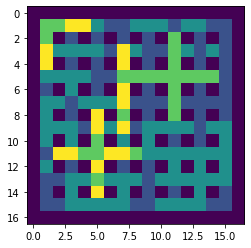

In [40]:
modified_crate_map = crate_map.copy() + 2*upcoming_explosion_mask



plt.imshow(modified_crate_map.T, vmin=-1, vmax=3)

In [ ]:
    # 2. Check for danger and lethal danger
    """
    going_is_dumb   : 
        Intuitive definition : going in that direction is suicidal
        Effect if True       : sets f1-f4 to 0
    waiting_is_dumb : 
        Intuitive definition : staying on own_position is suicidal
        Effect if True       : sets f5 to 0
    bombing_is_dumb : 
        Intuitive definition : placing a bomb on own_position is suicidal?
        Effect if True       : prevents f5 from being 2 via best_crate_bombing_spots() (only mode 1)
    """
    
    waiting_is_dumb = False
    bombing_is_dumb = False
    
    # Don't go where it's invalid or suicidal
    going_is_dumb   = np.array([( (not reachability_map[(x,y)]) or explosion_map[(x,y)] ) for [x,y] in neighbors])
    
    # Don't place a bomb if you're not able to
    if not can_place_bomb: 
        bombing_is_dumb = True
    
    # Escape bombs that are about to explode
    for (bomb_position, bomb_timer) in bombs:
        steps_until_explosion = bomb_timer + 1

        if not waiting_is_dumb:
            no_future_explosion_mask = np.logical_not(BOMB_MASK[bomb_position])
            rescue_distances         = distance_map[reachability_map & no_future_explosion_mask]   # improve by including explosions
            minimal_rescue_distance  = DEFAULT_DISTANCE if (rescue_distances.size == 0) else np.amin(rescue_distances)
            if steps_until_explosion <= minimal_rescue_distance:
                waiting_is_dumb = True
                bombing_is_dumb = True

        safe_directions = np.amax(direction_map[reachability_map & no_future_explosion_mask & (distance_map <= steps_until_explosion)], axis = 0, initial = False)
        going_is_dumb[np.logical_not(safe_directions)] = True

    # Don't place a bomb you can't escape from
    if not bombing_is_dumb:
        no_future_explosion_mask = np.logical_not(BOMB_MASK[own_position])
        rescue_distances         = distance_map[reachability_map & no_future_explosion_mask] # improve by including explosions
        minimal_rescue_distance  = DEFAULT_DISTANCE if (rescue_distances.size == 0) else np.amin(rescue_distances) 
        if minimal_rescue_distance >= 4:
                self.dumb_bombing_map[own_position] = True
                bombing_is_dumb = True
        elif self.dumb_bombing_map[own_position]:
            self.dumb_bombing_map[own_position] = False

In [43]:
def sensible_bombing_spots (reachability_map, dumb_bombing_map):
    return reachability_map * np.logical_not(dumb_bombing_map)

In [ ]:
def best_crate_bombing_spots (distance_map, number_of_destroyed_crates_map, sensible_bombing_map):
    """
    """

    total_time_map             = distance_map + BOMB_COOLDOWN_TIME   # Time until next bomb can be placed
    reachable_crates_destroyed = sensible_bombing_map * number_of_destroyed_crates_map   # Filtering out the reachable crate_destruction spots (precaution).
    destruction_speed_map      = reachable_crates_destroyed / total_time_map
    max_destruction_speed      = np.amax(destruction_speed_map)
    
    if max_destruction_speed > 0:
        best_spots_mask = np.isclose(destruction_speed_map, max_destruction_speed)   # Safer test for float equality
        best_spots      = np.array(np.where(best_spots_mask)).T
    else:
        best_spots      = np.array([])
    
    return best_spots

#### To do

**All functions**
* Rename `reachability_map` into `reachability_mask`

**`crate_goals`**
* Consider whether time until next bomb should be placed into total_time calculation.
* Consider whether explosion zones of bombs and subsequentla reachable spaces (should be added to reachable map etc.

**danger calculations**
* Consider merging `going_is_suicide` and `waiting_is_suicide`